# Convolutional nets for digit recognition

In this notebook we use a few convolutional neural nets (CNNs) to classify handwritten characters!

![Convolutional Neural Net on handwritten digits](../notebooks-img/cnn-mnist.png?raw=true "Convolutional Neural Net on handwritten digits")

This code builds on [an exercise](https://github.com/arturomp/udacity-deep-learning/blob/master/4_convolutions.ipynb) over [notMNIST](http://yaroslavvb.blogspot.ca/2011/09/notmnist-dataset.html) data for the Udacity Deep Learning [course](https://www.udacity.com/course/deep-learning--ud730), but with the Kaggle [digit recognition competition](https://www.kaggle.com/c/digit-recognizer) dataset. Some code is also taken from [the tensorflow website](https://www.tensorflow.org/get_started/mnist/pros).

In [88]:
from __future__ import print_function
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from collections import defaultdict, Counter
import os, sys, time
from IPython.display import display, Image
import matplotlib.pyplot as plt
import math

## Preparing (and visualizing) the data

We load the data and confirm it has the expected shape.

In [132]:
train = pd.read_csv("train.csv")
train = train.as_matrix()
test  = pd.read_csv("test.csv")
test  = test.as_matrix()

# Shapes of the training and test sets
print("Training set has {0[0]} rows and {0[1]} columns".format(train.shape))
print("Test set has {0[0]} rows and {0[1]} columns".format(test.shape))

Training set has 42000 rows and 785 columns
Test set has 28000 rows and 784 columns


We define a function to create a grid where we show a random sample of 100 handwritten digits from the training data.

In [ ]:
def displayData(X, example_width=None):

    plt.close()
    plt.figure(figsize=(10, 10))
    if X.ndim == 1:
        X = np.reshape(X, (-1,X.shape[0]))
    if not example_width or not 'example_width' in locals():
        example_width = int(round(math.sqrt(X.shape[1])))

    plt.set_cmap("gray")
    
    m, n = X.shape
    example_height = n / example_width
    display_rows = int(math.floor(math.sqrt(m)))
    display_cols = int(math.ceil(m / display_rows))

    pad = 1
    display_array = -np.ones((pad + display_rows * (example_height + pad),  \
                              pad + display_cols * (example_width + pad)))

    curr_ex = 1
    for j in xrange(1,display_rows+1):
        for i in xrange (1,display_cols+1):
            if curr_ex > m:
                break
        
            max_val = np.mean(abs(X[curr_ex-1, :]))
            rows = pad + (j - 1) * (example_height + pad) + np.array(range(example_height))
            cols = pad + (i - 1) * (example_width  + pad) + np.array(range(example_width ))

            display_array[rows[0]:rows[-1]+1 , cols[0]:cols[-1]+1] = \
                        np.reshape(X[curr_ex-1, :], (example_height, example_width), order="C") / max_val
            curr_ex += 1
    
        if curr_ex > m:
            break

    h = plt.imshow(display_array, vmin=-1, vmax=1)
    plt.axis('off')
    plt.show()

    return h, display_array    

And we use that function:

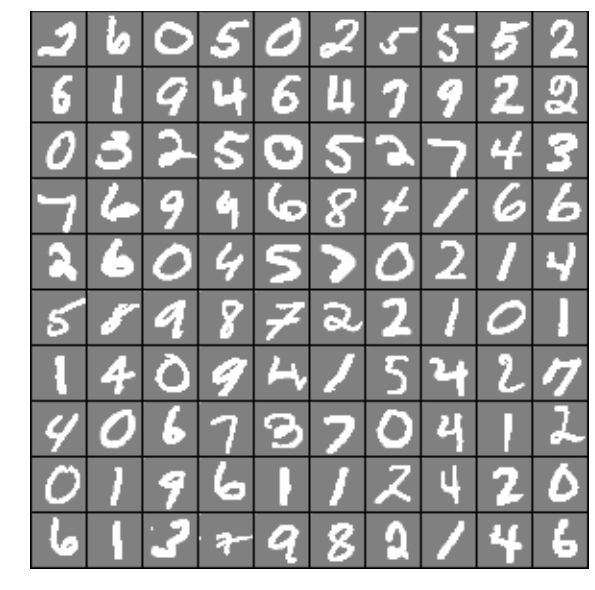

In [133]:
rand_indices = np.random.choice(np.arange(train.shape[0]), size=100, replace=False)
_, _ = displayData(train[rand_indices,:-1])

Then we divide the labelled data in random training and validation sets.

In [134]:
image_size = 28

def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def train_valid(data, train_size, valid_size=0):
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
    
  # shuffle the data to have random validation and training set
  np.random.shuffle(data)
  if valid_dataset is not None:
    valid_dataset = data[:valid_size, 1:].reshape((-1, image_size, image_size))
    valid_labels  = data[:valid_size, :1].ravel()
              
  train_dataset = data[valid_size:, 1:].reshape((-1, image_size, image_size))
  train_labels  = data[valid_size:, :1].ravel()
    
  return valid_dataset, valid_labels, train_dataset, train_labels

We determine the number of validation examples and, by consequence, the number of training examples. Since we won't be tuning parameters here, we set ``valid_size=0``.

In [135]:
valid_size =  0
train_size = len(train) - valid_size

In [136]:
valid_dataset, valid_labels, train_dataset, train_labels = train_valid(
  train, train_size, valid_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test.shape)

Training: (38000, 28, 28) (38000,)
Validation: (4000, 28, 28) (4000,)
Testing: (28000, 784)


We'll use an accuracy metric to evaluate the model's performance.

In [137]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

We'll distinguish amongst handwritten digits from 0 to 9, so we have ``num_labels=10``. We only have one channel color because the images are in grayscale.

In [138]:
num_labels = 10
num_channels = 1 # grayscale

We also need to map the digit labels to one-hot encoding.

In [139]:
# map labels to one-hot encoding
def reformat(dataset, labels=None):
  dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
  if labels is not None:
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

We then verify the new label matrix shapes have 10 dimensions (vs previously 1).

In [140]:
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset , _            = reformat(test)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test.shape)

Training set (38000, 28, 28, 1) (38000, 10)
Validation set (4000, 28, 28, 1) (4000, 10)
Test set (28000, 784)


## Defining the CNN

We define useful functions to create weights and biases, since we'll need a few of them.

We initialize the weights with some noise for symmetry breaking and to avoid 0 gradients. Additionally, we prevent having useless neurons by having a slight positive bias since we're using ReLU neurons.

In [141]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

Further, with the functions below we define the convolutions. We'll have a stride of 1 and 0-padding to produce an output that is the same size as the input. Pooling is done with max pooling over 2x2 blocks.

In [142]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

There's a few knobs to adjust for our neural net. We start by setting out some constants.

In [167]:
batch_size = 50
patch_size = 5
depth = 32
num_hidden = 1024
num_steps = 30001
pattern = "01"

And define a function to run our whole neural net. The comments explain more in detail the architecture and steps involved in performing batch gradient descent over a 2-convolution neural net with ReLU units, max pooling and dropout.

Note that each time we run the network we'll output a predictions file based on its ``learning_rate`` and ``keep_rate`` values.

In [168]:
def runCNNet(learning_rate, keep_rate):
    
    graph = tf.Graph()

    with graph.as_default():

        # input image + target output classes
        x = x_image = tf.placeholder(tf.float32, shape=[None,image_size, image_size, num_channels]) 
        y_ = tf.placeholder(tf.float32, shape=[None, num_labels])

        # first convolution
        # 32 features for each 5x5 patch
        W_conv1 = weight_variable([patch_size, patch_size, num_channels, depth])
        b_conv1 = bias_variable([depth])

        # relu + max pooling
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
        h_pool1 = max_pool_2x2(h_conv1)

        # second convolution
        # 64 features for each 5x5 patch
        W_conv2 = weight_variable([patch_size, patch_size, depth, depth*2])
        b_conv2 = bias_variable([depth*2])

        # relu + max pooling
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = max_pool_2x2(h_conv2)

        # fully connected hidden layer + relu
        W_fc1 = weight_variable([image_size // 4 * image_size // 4 * depth*2, num_hidden])
        b_fc1 = bias_variable([num_hidden])
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

        # dropout
        keep_prob = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

        # readout layer
        W_fc2 = weight_variable([num_hidden, num_labels])
        b_fc2 = bias_variable([num_labels])
        y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
        
        # training computation
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
        
        # optimizer
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
        
        # predictions for the test data
        correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        t = time.time()
        
        for i in range(num_steps):

            batch = [None]*2

            # batch gradient descent
            offset = (i * batch_size) % (train_labels.shape[0] - batch_size)
            batch[0] = train_dataset[offset:(offset + batch_size), :, :, :]
            batch[1] = train_labels[offset:(offset + batch_size), :]

            if i%5000 == 0:
                train_accuracy = accuracy.eval(feed_dict={
                    x:batch[0], y_: batch[1], keep_prob: 1.0})
                print("step {:d}, training accuracy {:g}".format(i, train_accuracy))

            if (i % (num_steps-1) == 0 and i > 0):
                acc = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
                print('\n{:.2f}%  lr: {:g}, kr: {:g}'.format(acc*100, learning_rate, keep_rate))
                
            train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: keep_rate})

        print("Train time: {:.3f} sec".format(time.time() - t))

        # make predictions on test data
        kaggle_pred = y_conv.eval(feed_dict={x:test_dataset, keep_prob: 1.0})
        
        print(kaggle_pred.shape)
        
        # export predictions in Kaggle-acceptable format
        pred_filename = "notebook"+"_"+str(learning_rate)+"_"+str(keep_rate)+"_"+str(acc)+"_"+pattern+".csv"
        kaggle_pred = pd.concat([pd.Series(np.arange(kaggle_pred.shape[0])), pd.Series(kaggle_pred.argmax(axis=1))], axis=1)
        kaggle_pred.columns = ["ImageId","Label"]
        kaggle_pred.to_csv(pred_filename, index=False)
        
        return 

## Training the CNN

Finally, we run the neural net over 6 different ``learning_rate`` and ``keep_rate`` combinations.

Later we'll combine their results into a consensus prediction.

In [169]:
for learning_rate in [1e-3, 1e-4]:
    for keep_rate in [1, 0.95, 0.9]:
        runCNNet(learning_rate, keep_rate)

step 0, training accuracy 0.04
step 5000, training accuracy 0.98
step 10000, training accuracy 0.98
step 15000, training accuracy 0.98
step 20000, training accuracy 1
step 25000, training accuracy 1
step 30000, training accuracy 1

100.00%  lr: 0.001, kr: 1
Train time: 4163.480 sec
(28000, 10)
step 0, training accuracy 0.1
step 5000, training accuracy 0.98
step 10000, training accuracy 1
step 15000, training accuracy 1
step 20000, training accuracy 1
step 25000, training accuracy 1
step 30000, training accuracy 1

100.00%  lr: 0.001, kr: 0.95
Train time: 4075.135 sec
(28000, 10)
step 0, training accuracy 0.08
step 5000, training accuracy 0.98
step 10000, training accuracy 1
step 15000, training accuracy 1
step 20000, training accuracy 1
step 25000, training accuracy 1
step 30000, training accuracy 1

100.00%  lr: 0.001, kr: 0.9
Train time: 4064.931 sec
(28000, 10)
step 0, training accuracy 0.12
step 5000, training accuracy 1
step 10000, training accuracy 1
step 15000, training accuracy

Training these 6 neural nets took training took around 25,035 seconds $\approx$ 7 hours.

## Getting to Yes

Now we gather all the prediction files generated to get consensus predictions from them.

In [170]:
files = [f for f in os.listdir(os.getcwd()) if pattern+".csv" in f]

id_dict = defaultdict(Counter)

Then we make them vote on each test sample classification.

In [171]:
for f in files:

    ids  = pd.read_csv(f)
    ids  = ids.as_matrix()

    for i, num in ids:
        id_dict[i][num] += 1

And we tally the votes and break any possible ties.

In [182]:
kaggle_pred = []
for k in sorted(id_dict.keys()):
    if len(id_dict[k].keys()) > 1:
        if len(set(id_dict[k].values()))==1: # all digits have the same number of votes
            kaggle_pred.append(id_dict[k].most_common()[0][0]) # get the first tied result
            # kaggle_pred.append(id_dict[k].most_common()[1][0]) # get the second tied result
            # kaggle_pred.append(id_dict[k].most_common()[-1][0]) # get the last tied result
        else:
            kaggle_pred.append(id_dict[k].most_common()[0][0]) # get the most common
    else:
        kaggle_pred.append(id_dict[k].keys()[0])

We export the consensus predictions.

In [183]:
pred_filename = "notebook_consensus.csv"
kaggle_pred = pd.concat([pd.Series(np.arange(1,len(kaggle_pred)+1)), pd.Series(kaggle_pred)], axis=1)
kaggle_pred.columns = ["ImageId","Label"]
kaggle_pred.to_csv(pred_filename, index=False)

## Kaggle submission

The results are very good, considering that there has been little tuning to the net's parameters.

![Predictions score: 0.99129](../notebooks-img/notebook_consensus_wide.png?raw=true "Predictions score: 0.99129")